## Regression: Forward stepwise selection on car mpg

First, we will run multiple linear regression on the Auto dataset and use subset selection to find the best model. This dataset contains the following nine columns from 392 cars:

|Column|Description|
|:-|:-|
|mpg| continuous|
|cylinders| multi-valued discrete|
|displacement| continuous|
|horsepower| continuous|
|weight| continuous|
|acceleration| continuous|
|model year| multi-valued discrete|
|origin| multi-valued discrete|
|car name| string|

In [4]:
#Data Wrangling
import pandas as pd
import numpy as np

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

#Metrics
import itertools
import time
from sklearn.metrics import mean_squared_error

#Models
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV


from sklearn.model_selection import KFold


In [5]:
#Read & Check Data
auto_data_raw = pd.read_csv("Auto.csv")
auto = auto_data_raw.copy()
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


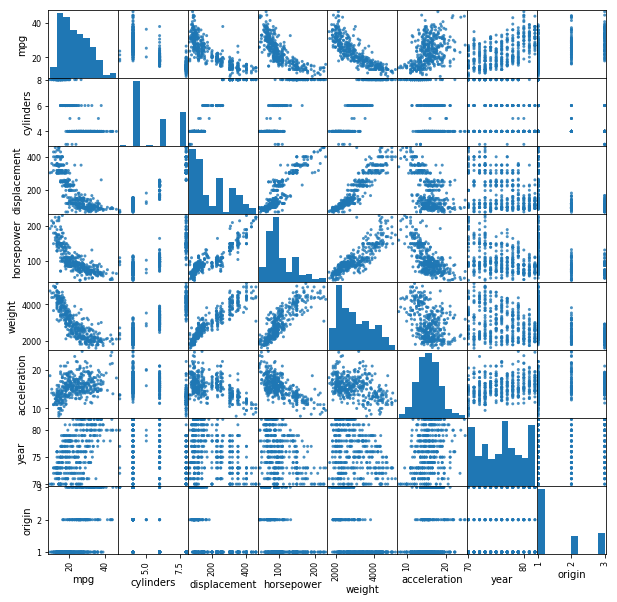

In [6]:
#Scatter Plot all variables
scatter_matrix(auto, alpha=0.8, figsize=(10, 10), diagonal='hist')
plt.show()

Now we compute a matrix of correlations between the variables.

In [9]:
corr_matrix = auto.corr()
corr_matrix

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


Now we'll use `Stats Models` to perform linear regression with 'mpg' as the response variable and all other variables except 'name' as predictors.

In [10]:
X_t = sm.add_constant(auto[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']])

# Fit the linear regression model
model = sm.OLS(auto['mpg'], X_t).fit()

# Print the summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Tue, 17 Oct 2023   Prob (F-statistic):          2.04e-139
Time:                        14:37:24   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Based on the results, the strongest predictors are displacements, weight, year, and origin.

Now we'll manually perform forward stepwise selection. The first model will have a single variable, and we'll select the best model using training RSS as the performance metric. We will continue adding one variable at a time until all variables have been added.  Afterwards, we'll calculate the test RSS of all the models and select the one that <b>minimizes</b> test RSS. 

The listed models for each round of selection will be stored in within 'chosen_models'. The list of selected variables will be stored in 'predictors_forward'.

In [14]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    # add in a column of ones as intercept
    X_t = sm.add_constant(X_train[list(feature_set)])
    model = sm.OLS(y_train, X_t)
    regression = model.fit()
    # RSS is the Residual Sum of Squares
    RSS = (regression.resid ** 2).sum()
    return {
        'model': regression,
        'RSS': RSS
    }
    
def getBest(k):
    tic = time.time()
    results = []
    # Fit all p choose k models with k predictors
    for combo in itertools.combinations(X_train.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the smallest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print ('Processed ', models.shape[0], 
           ' models on ', k, ' predictors in ',
          (toc - tic), ' seconds.') #count the time in between
    
    # Return the best model, along with other useful information
    return best_model

def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors= [p for p in X_train.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors + [p]))
        
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the smallest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print ('Processed ', models.shape[0], ' models on ', len(predictors) + 1, 
          ' predictors in ', (toc - tic), ' seconds.')
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [15]:
y = auto['mpg']
X = auto[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = sm.add_constant(X_test)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [16]:
models2 = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X_train.columns)+1):
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]["model"].model.exog_names[1:]

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

models2

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Processed  7  models on  1  predictors in  0.035449981689453125  seconds.
Processed  6  models on  2  predictors in  0.029742002487182617  seconds.
Processed  5  models on  3  predictors in  0.026942729949951172  seconds.
Processed  4  models on  4  predictors in  0.02521228790283203  seconds.
Processed  3  models on  5  predictors in  0.020473957061767578  seconds.
Processed  2  models on  6  predictors in  0.01597881317138672  seconds.
Processed  1  models on  7  predictors in  0.010532379150390625  seconds.
Total elapsed time: 0.1917436122894287 seconds.


,RSS,model
1,5961.118240,<statsmodels.regression.linear_model.Regressio...
2,3752.032912,<statsmodels.regression.linear_model.Regressio...
3,3495.974375,<statsmodels.regression.linear_model.Regressio...
4,3474.203553,<statsmodels.regression.linear_model.Regressio...
5,3447.726465,<statsmodels.regression.linear_model.Regressio...
6,3437.837334,<statsmodels.regression.linear_model.Regressio...
7,3436.507079,<statsmodels.regression.linear_model.Regressio...


In [17]:
RSS_test_forward = []
predictors = []

for n in range(1,len(models2)):
    feature_set2 = models2.loc[n, "model"].params.index
    predictors.append(list(feature_set2))
    predictors_forward = list(feature_set2)
    y_pred2 = models2.loc[n, "model"].predict(
                    X_test[list(feature_set2)])
    RSS_test_forward.append(sum((y_test-y_pred2)**2))
    
print(RSS_test_forward)
print(predictors)

[1397.777673294109, 829.9182265112305, 875.9005429321542, 884.5759640597257, 865.716037125167, 850.37681063302]
[['const', 'weight'], ['const', 'weight', 'year'], ['const', 'weight', 'year', 'origin'], ['const', 'weight', 'year', 'origin', 'horsepower'], ['const', 'weight', 'year', 'origin', 'horsepower', 'displacement'], ['const', 'weight', 'year', 'origin', 'horsepower', 'displacement', 'cylinders']]


The best model only consists of 'year' and 'weight' having the loswest test RSS of 829.9.